### Load dataset and save IRs

In [1]:
from diff_gfdn.dataloader import ThreeRoomDataset, load_dataset
from diff_gfdn.config.config import DiffGFDNConfig
from diff_gfdn.model import DiffGFDN
from diff_gfdn.utils import get_response, db, is_unitary, absorption_to_gain_per_sample
from diff_gfdn.losses import get_stft_torch, get_edr_from_stft
from run_model import load_and_validate_config

from pathlib import Path
from typing import Tuple, Optional
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchaudio
import soundfile as sf
from loguru import logger

### Helper functions

In [3]:
def plot_spectrogram(S: torch.tensor, freqs: ArrayLike, time_frames: ArrayLike, title:Optional[str]=None):
    plt.figure()
    plt.imshow(db(np.abs(S)).cpu().detach().numpy(), aspect='auto', origin='lower',
    extent=[time_frames.min(), time_frames.max(), freqs.min(), freqs.max()])
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    cbar = plt.colorbar()
    cbar.set_label('dB')
    if title is not None:
        plt.title(title)
    plt.show()


def plot_edr(h: torch.tensor, 
             fs: float, 
             win_size:int=2**9, 
             hop_size:int=2**8, 
             title:Optional[str]=None) -> Tuple[torch.tensor, ArrayLike, ArrayLike]:
    S, freqs, time_frames = get_stft_torch(h, fs, win_size=win_size, hop_size=hop_size, nfft=win_size, freq_axis=0)
    edr = get_edr_from_stft(S)
    plot_spectrogram(edr, freqs, time_frames,title)
    return edr

### Read config files and dataset

In [4]:
config_path = '../data/config/'
config_file = config_path + 'antialiasing_sample_outside_unit_circle.yml'
config_dict = load_and_validate_config(config_file,
                                       DiffGFDNConfig)
room_data = ThreeRoomDataset(Path(config_dict.room_dataset_path).resolve(), config_dict=config_dict,save_irs=False)

# add number of groups to the config dictionary
config_dict = config_dict.copy(update={"num_groups": room_data.num_rooms})

if config_dict.sample_rate != room_data.sample_rate:
    logger.warn("Config sample rate does not match data, alterning it")
    config_dict.sample_rate = sample_rate

# get the training config
trainer_config = config_dict.trainer_config

# prepare the training and validation data for DiffGFDN
train_dataset, valid_dataset = load_dataset(
    room_data, trainer_config.device, trainer_config.train_valid_split,
    trainer_config.batch_size)

2024-10-08 17:13:29.541 | INFO     | diff_gfdn.dataloader:__init__:256 - Reading pkl file ...
2024-10-08 17:13:34.614 | INFO     | diff_gfdn.dataloader:__init__:273 - Done reading pkl file
2024-10-08 17:13:40.601 | INFO     | diff_gfdn.dataloader:split_dataset:427 - Length of the dataset is 838
2024-10-08 17:13:40.651 | INFO     | diff_gfdn.dataloader:split_dataset:436 - The size of the training set is 670 and the size of the validation set is 168


### Check output data and compare with true IR

In [5]:
# initialise the model
model = DiffGFDN(room_data.sample_rate, room_data.num_rooms,
                 config_dict.delay_length_samps,
                 room_data.room_dims,
                 trainer_config.device, 
                 config_dict.feedback_loop_config,
                 config_dict.output_filter_config,
                 config_dict.use_absorption_filters,
                 common_decay_times=room_data.common_decay_times,
                 band_centre_hz=room_data.band_centre_hz
                )

In [6]:
audio_directory  = Path("../audio/")
checkpoint_dir = Path(trainer_config.train_dir + '/checkpoints/').resolve()
max_epochs = trainer_config.max_epochs
save_ir_dir = Path(trainer_config.ir_dir).resolve() 
save_ir = False
plot_ir = not save_ir  

In [7]:
for epoch in range(max_epochs):
    # load the trained weights for the particular epoch
    checkpoint = torch.load(f'{checkpoint_dir}/model_e{epoch}.pt', weights_only=True, map_location=trainer_config.device)
    # Load the trained model state
    model.load_state_dict(checkpoint)
    # in eval mode, no gradients are calculated
    model.eval()
    
    for data in train_dataset:
        position = data['listener_position']
        H, h = get_response(data, model)
        
        for num_pos in range(position.shape[0]):
            filename = f'ir_({position[num_pos,0]:.2f}, {position[num_pos, 1]:.2f}, {position[num_pos, 2]:.2f}).wav'
            
            # find the true IR corresponding to this position
            filepath_true = os.path.join(Path(audio_directory/'true').resolve(), filename)
            h_true = torch.from_numpy(sf.read(filepath_true)[0])

            if plot_ir:
                # plot the EDRs of the true and estimated
                plot_edr(h_true, model.sample_rate, title=f'True RIR EDR, epoch={epoch}')
                plot_edr(h[num_pos, :], model.sample_rate, title=f'Estimated RIR EDR, epoch={epoch}')
        
                plt.figure()
                plt.plot(torch.stack((h_true, h[num_pos, :len(h_true)]), dim=-1))
                plt.show()

            if save_ir and (epoch == max_epochs - 1):
                outer_loop_break = False
                filepath = os.path.join(save_ir_dir, filename)
                torchaudio.save(filepath,
                            torch.stack((h[num_pos, :], h[num_pos, :]),
                                        dim=1).cpu(),
                            int(model.sample_rate),
                            bits_per_sample=32,
                            channels_first=False)
            else:
                outer_loop_break = True
                break
                
        if outer_loop_break:
            break

LibsndfileError: Error opening '/Users/dalsag1/Dropbox (Aalto)/aalto/projects/orchi/DiffGFDN/audio/true/ir_(3.80, 5.90, 1.50).wav': System error.

### Get the final trained parameters and investigate them

In [8]:
from scipy.io import loadmat
param_path = Path(trainer_config.train_dir + '/parameters_opt.mat')
opt_params = loadmat(param_path.resolve())
print(opt_params.keys())

dict_keys(['__header__', '__version__', '__globals__', 'delays', 'gains_per_sample', 'input_gains', 'individual_mixing_matrix', 'coupling_matrix', 'coupled_feedback_matrix', 'output_svf_params', 'output_biquad_coeffs', 'feedback_loop.M', 'feedback_loop.alpha', 'output_filters.mlp.model.0.weight', 'output_filters.mlp.model.0.bias', 'output_filters.mlp.model.1.weight', 'output_filters.mlp.model.1.bias', 'output_filters.mlp.model.3.weight', 'output_filters.mlp.model.3.bias', 'output_filters.mlp.model.4.weight', 'output_filters.mlp.model.4.bias', 'output_filters.mlp.model.6.weight', 'output_filters.mlp.model.6.bias'])


#### Observe the individual mixing matrices

tensor(2.3842e-07)
tensor(1.7881e-07)
tensor(2.3842e-07)


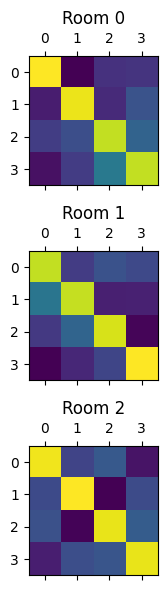

In [9]:
from importlib import reload
import diff_gfdn
reload(diff_gfdn.utils)
from diff_gfdn.utils import is_unitary

M_list = opt_params['feedback_loop.M']
num_groups = model.num_groups
fig, ax = plt.subplots(num_groups, 1, figsize=(6,6))

for i in range(num_groups):
    M = torch.from_numpy(M_list[i, ...])
    with torch.no_grad():
        M_ortho = model.feedback_loop.ortho_param(M)
    ax[i].matshow(torch.abs(M_ortho))
    ax[i].set_title(f'Room {i}')
    is_ortho, max_val = is_unitary(M_ortho)
    print(max_val)
plt.tight_layout()

#### Observe the input gains, coupling matrix and the coupled mixing matrix

0.15443042


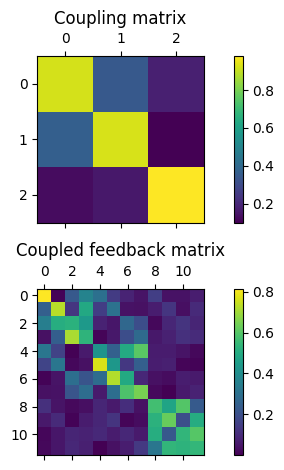

In [10]:
alpha = opt_params['feedback_loop.alpha'][0]
coupled_feedback_matrix = opt_params['coupled_feedback_matrix']
assert is_unitary(torch.from_numpy(coupled_feedback_matrix))[0]

input_gains = opt_params['input_gains'][0]
print(np.linalg.norm(input_gains))

with torch.no_grad():
    coupling_matrix =model.feedback_loop.nd_unitary(torch.from_numpy(alpha), room_data.num_rooms)
    unit_flag, max_val = is_unitary(coupling_matrix)
    assert unit_flag
    
plt.figure()
plt.subplot(211)
plt.matshow(torch.abs(coupling_matrix), fignum=False)
plt.colorbar()
plt.title('Coupling matrix')
plt.subplot(212)
plt.matshow(np.abs(coupled_feedback_matrix), fignum=False)
plt.colorbar()
plt.title('Coupled feedback matrix')
plt.tight_layout()

#### Plot the output filter response for a few positions

/var/folders/3l/7_dsnxg54ngcd4f6xxw46mvr0000gp/T/ipykernel_6790/1625537511.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()  # Create a new figure and axis for each outer loop iteration


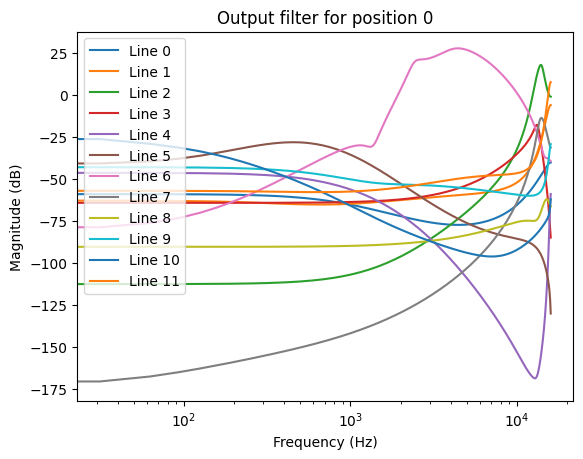

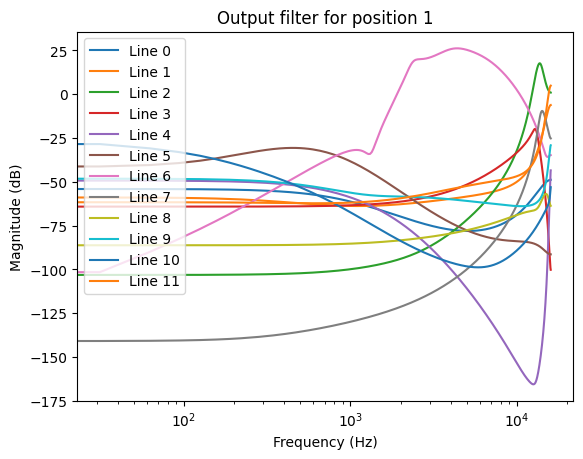

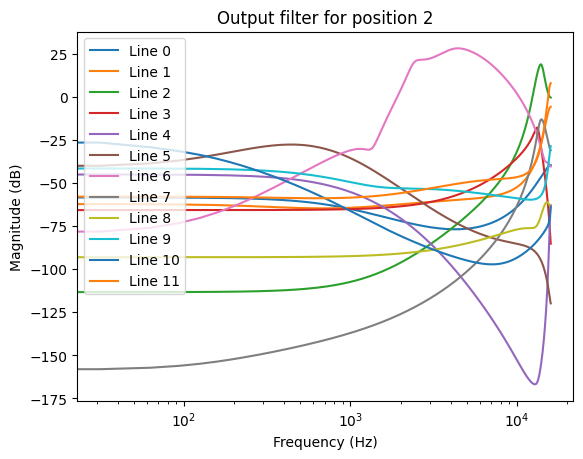

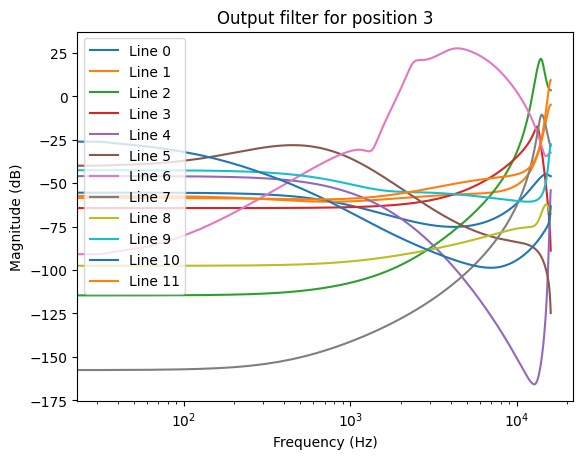

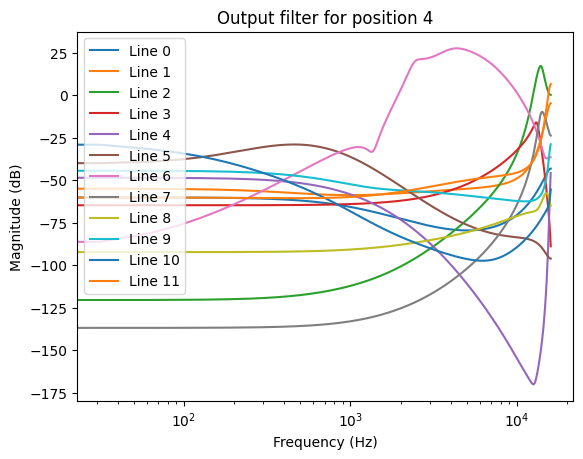

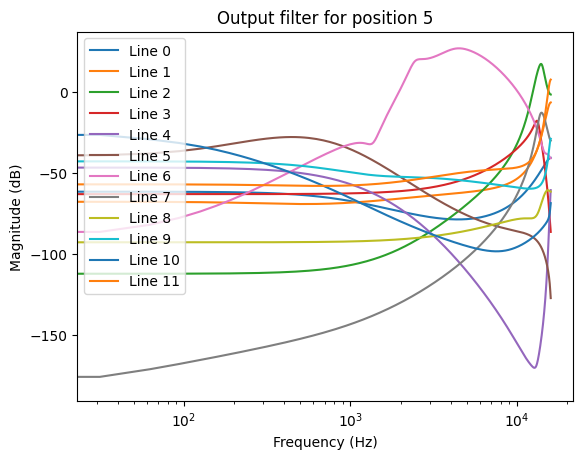

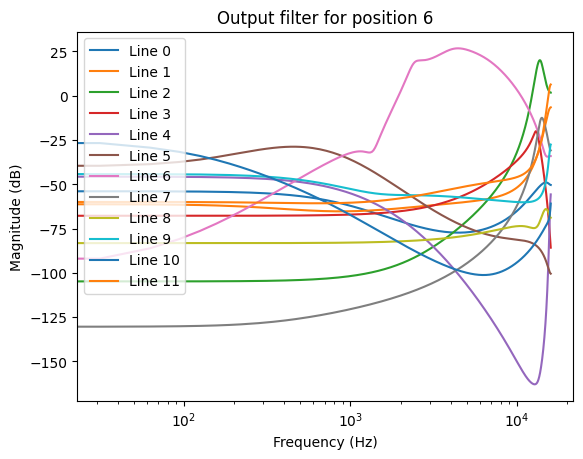

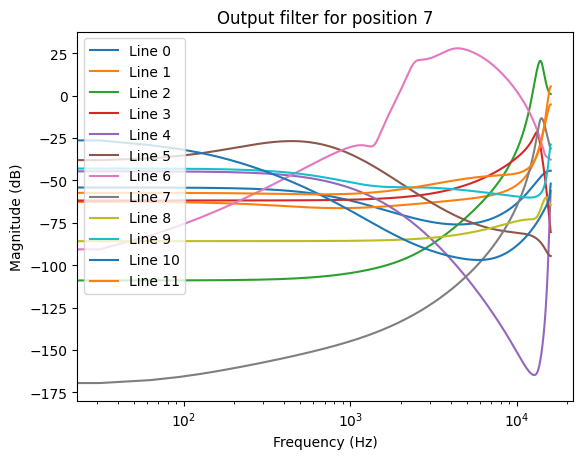

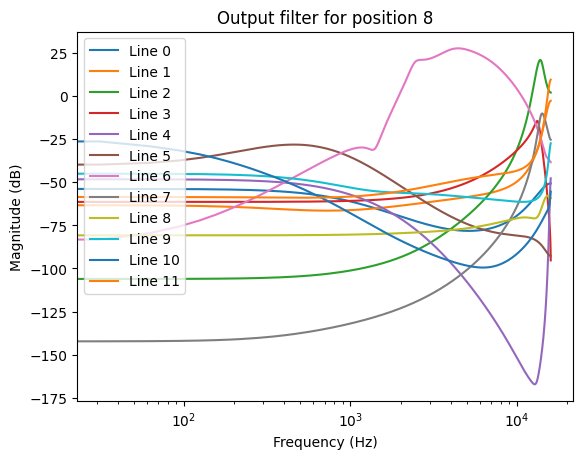

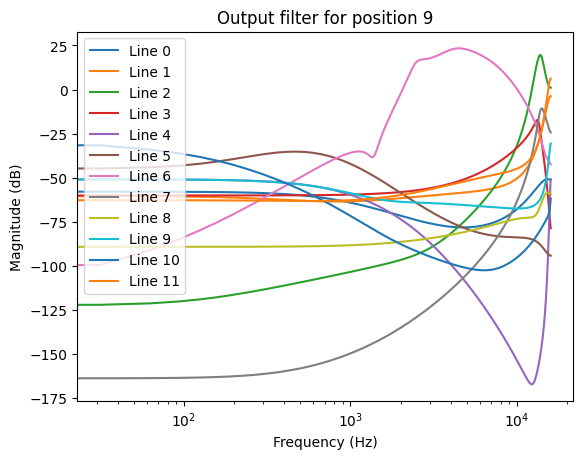

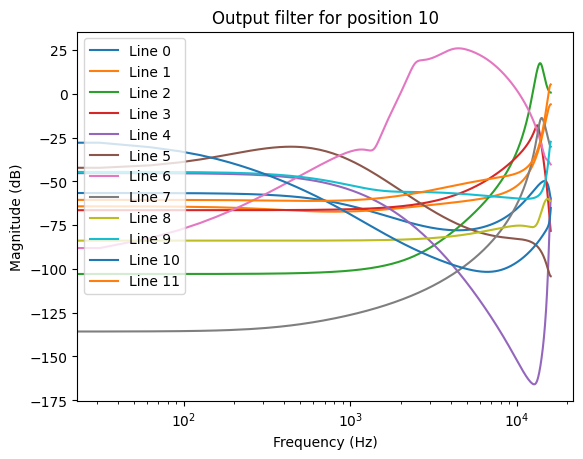

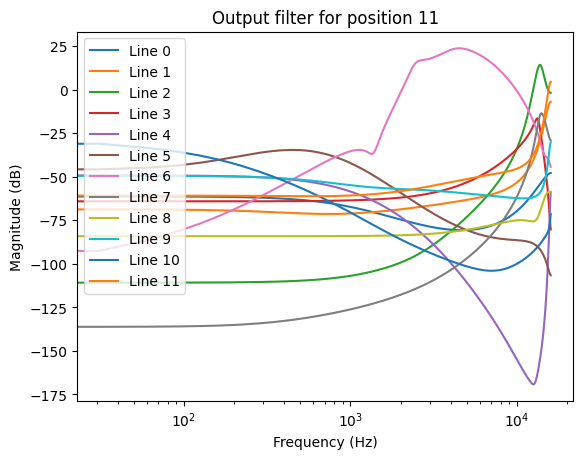

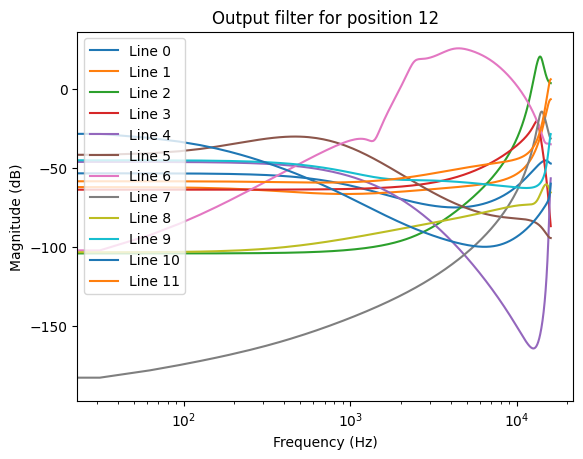

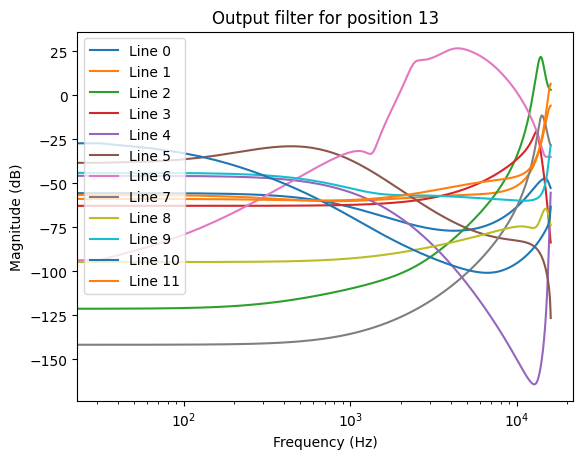

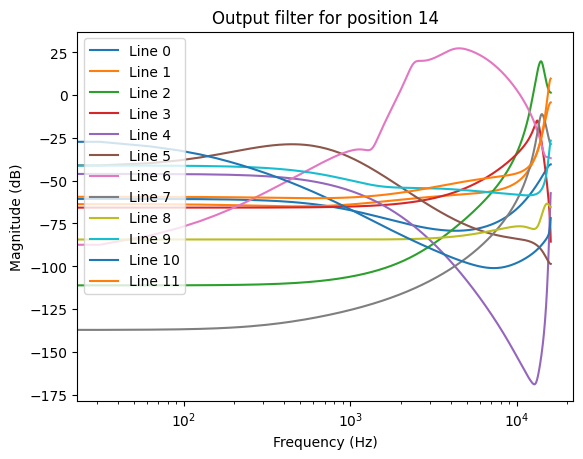

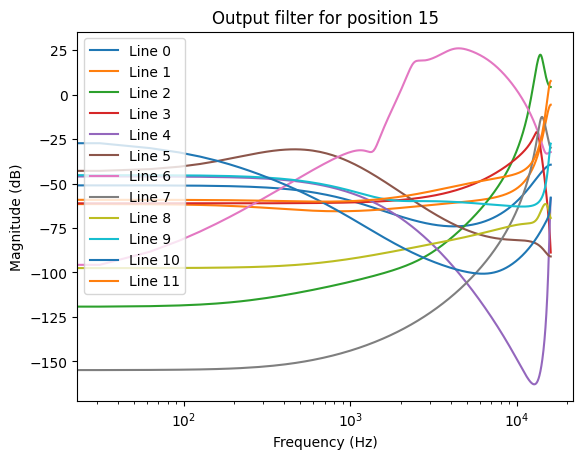

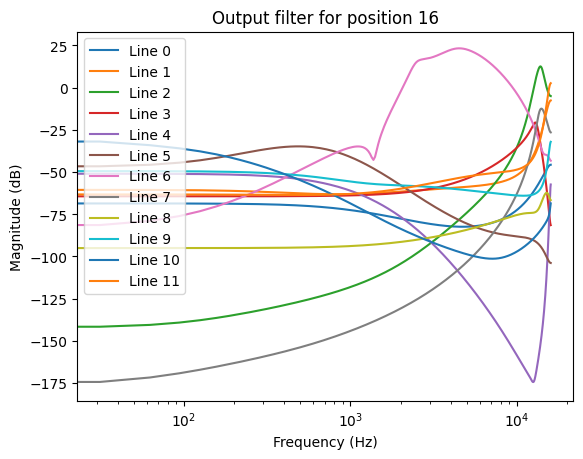

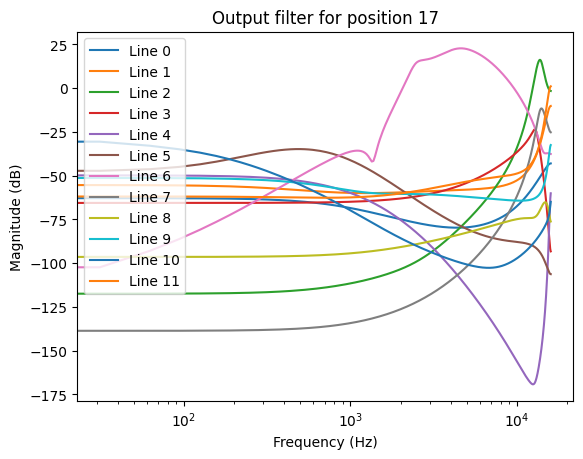

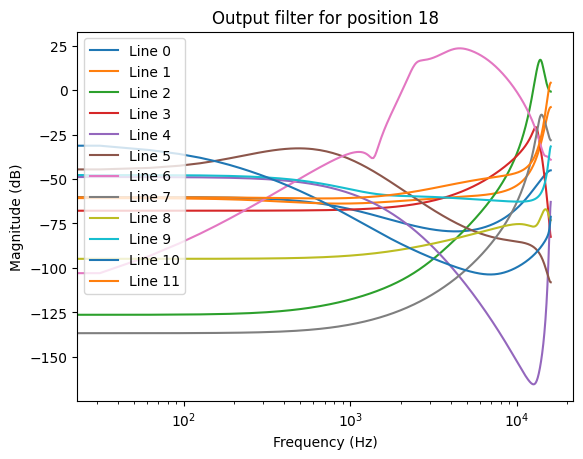

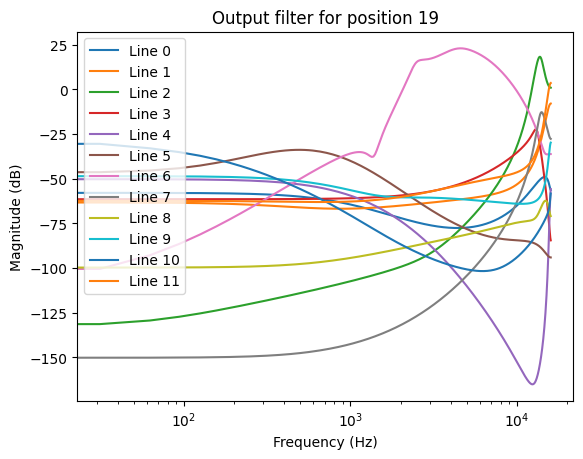

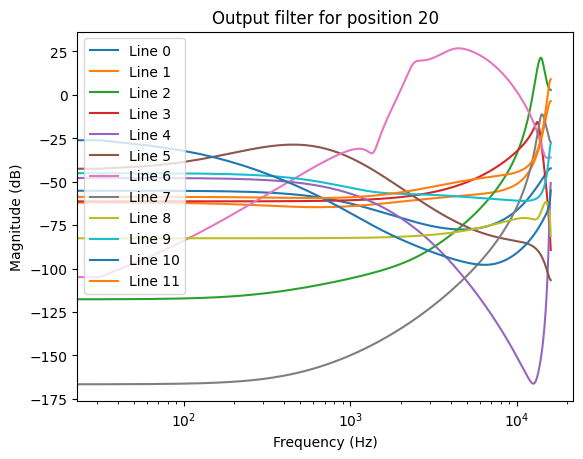

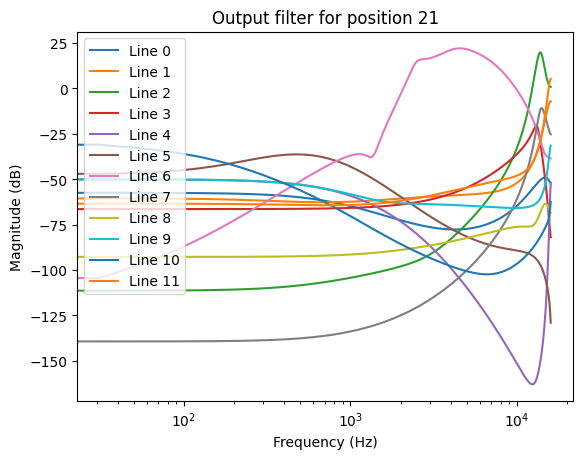

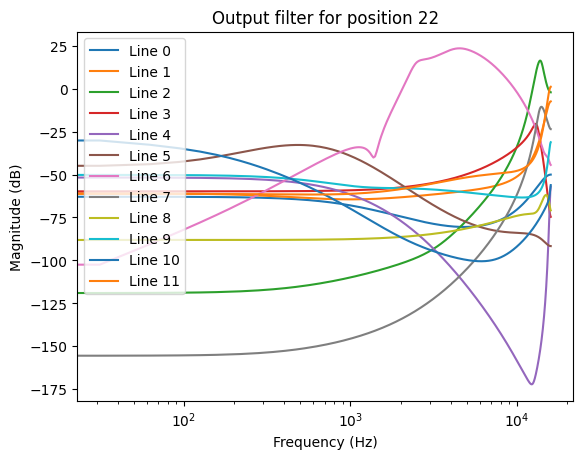

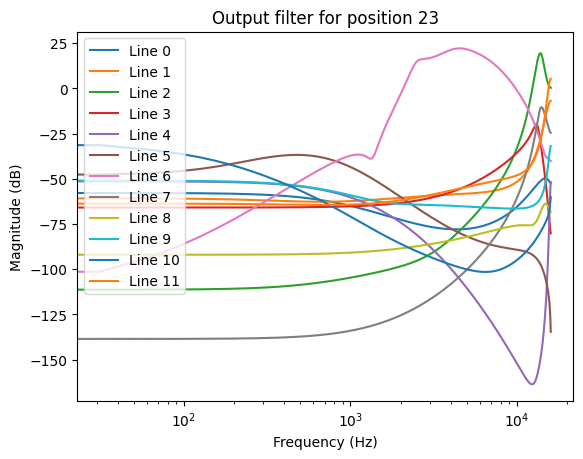

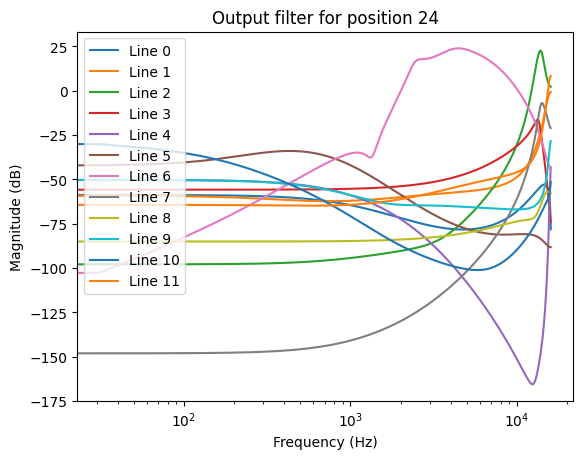

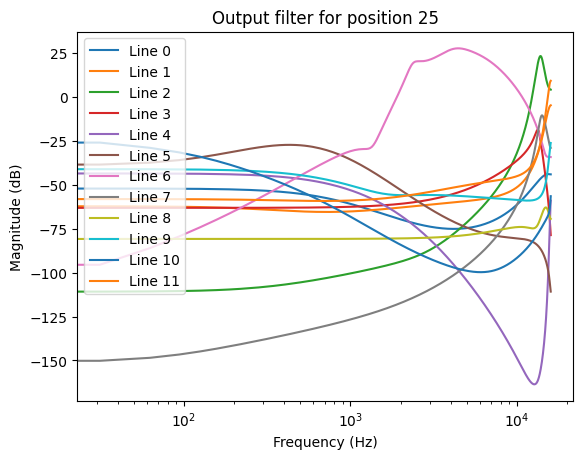

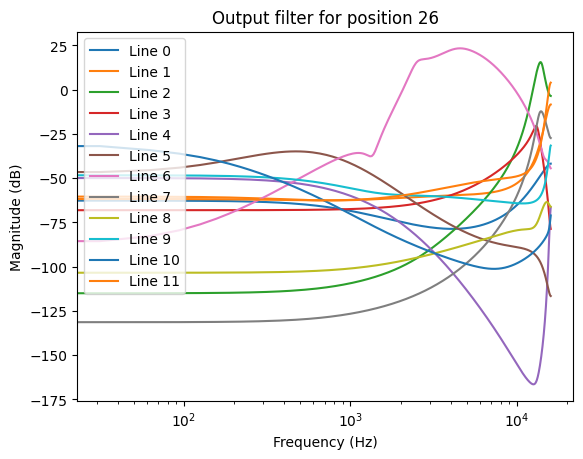

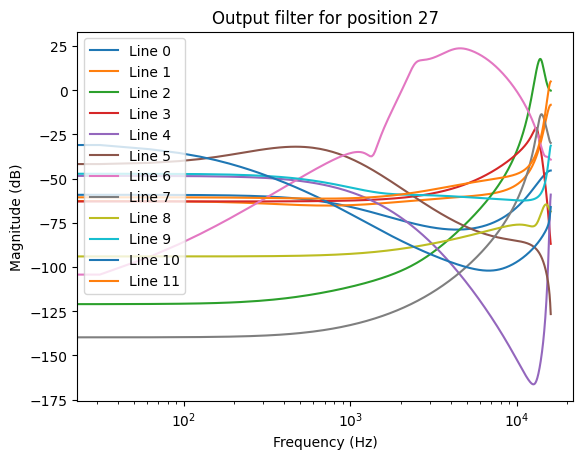

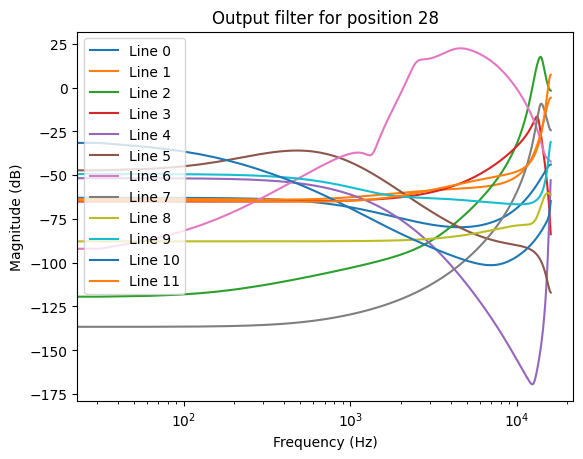

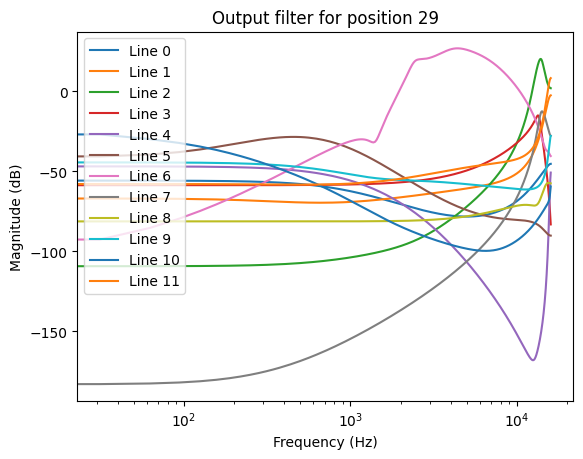

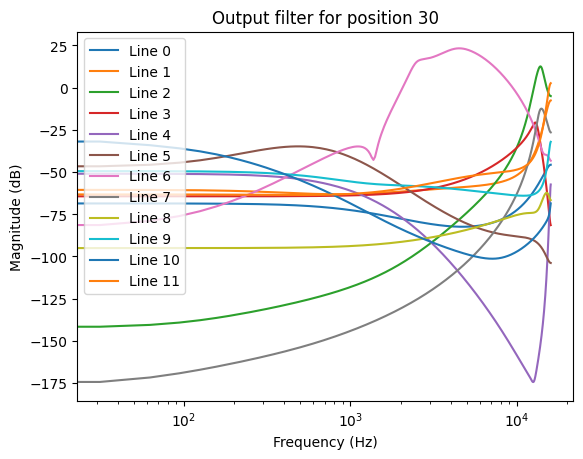

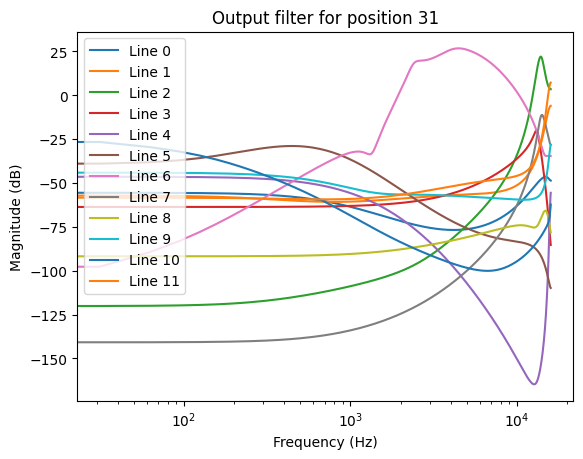

In [11]:
from scipy.signal import sosfreqz
output_biquad_coeffs = opt_params['output_biquad_coeffs']
delays = opt_params['delays'][0]

for b in range(len(output_biquad_coeffs)):
    fig, ax = plt.subplots()  # Create a new figure and axis for each outer loop iteration
    for n in range(len(delays)):
        cur_biquad_coeffs = output_biquad_coeffs[b][n]
        # ensure a0 = 1 (needed by scipy)
        for k in range(cur_biquad_coeffs.shape[0]):
            cur_biquad_coeffs[k,:] /= cur_biquad_coeffs[k, 3]

        freqs, filt_response = sosfreqz(cur_biquad_coeffs, worN=2**9, fs=room_data.sample_rate)
        ax.semilogx(freqs, 20*np.log10(np.abs(filt_response)), label=f'Line {n}')
        
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude (dB)')
    ax.set_title(f'Output filter for position {b}')
    ax.legend()